In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [2]:
rows, cols, sigma = 250, 100, 5.0
coefficients1 = [1,1,-1]
coefficients2 = [2,-1,1]
degree1 = 2
degree2 = 2

In [3]:
t_values = np.linspace(-10, 10, cols)
shifted_t_values = np.polyval(coefficients1,t_values)

In [4]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_time_matrix(rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    for col in range(cols):
        for row in range(rows):
            matrix[row, col] = gaussian(row, rows / 2, sigma)
    matrix /= np.max(matrix)
    
    return matrix


In [5]:
Q_orig = create_gaussian_time_matrix(rows, cols, sigma)

# Cubic interpolation and shifting

In [6]:
class SplineInterpolation:
    def __init__(self, params):
        self.params = params
        self.A1, self.D1, self.D2, self.R = self.give_spline_coefficient_matrices()

    def give_spline_coefficient_matrices(self):
        Nxi = params['geometry']['Nxi']
        # Initialize matrices
        # Create the A1 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([1, 2, 1])
        offsets = [-1, 0, Nxi-1]
        A1_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        A1 = torch.tensor(A1_np, dtype=torch.float64)

        # Create the D1 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([-1, 1, -1])
        D1_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        D1 = torch.tensor(D1_np, dtype=torch.float64)

        # Create the D2 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([1, 1, -2, 1, 1])
        offsets = [-(Nxi-1), -1, 0, 1, Nxi-1]
        D2_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        D2 = torch.tensor(D2_np, dtype=torch.float64)

        # Create the M matrix and compute its Cholesky decomposition
        diagonals = np.ones((Nxi, 1)) * np.array([1, 1, 4, 1, 1])
        M_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        R_np = cholesky(M_np)
        R = torch.tensor(R_np, dtype=torch.float64)
        
        return A1, D1, D2, R

    def construct_spline_coeffs_periodic(self, qs):
        n = qs.shape[1]
        #import pdb; pdb.set_trace()
        # grid size:
        dxi = params['geometry']['dxi']

        # compute the spline coefficients:
        if qs.ndim == 1:  # case of just one data set
            spline_coeffs = {
                'a': qs,
                'c': (3 / dxi ** 2) * torch.solve(D2 @ qs, R)[0],
                'b': None,
                'd': None
            }
            spline_coeffs['b'] = (1 / dxi) * (self.D1 @ qs) + (dxi / 3) * (self.A1 @ spline_coeffs['c'])
            spline_coeffs['d'] = (1 / (3 * dxi)) * (self.D1 @ spline_coeffs['c'])
        else:  # case of multiple data sets
            spline_coeffs = {'a': qs, 'b': qs.clone(), 'c': qs.clone(), 'd': qs.clone()}
            #import pdb; pdb.set_trace()
            for i in range(n):
                # Assign the solved result to spline_coeffs
                spline_coeffs['c'][:, i] = (3 / dxi**2) * torch.linalg.solve(self.R, torch.linalg.solve(self.R.T, self.D2 @ qs[:, i]))
                spline_coeffs['b'][:, i] = (1 / dxi) * (self.D1 @ qs[:, i]) + (dxi / 3) * (self.A1 @ spline_coeffs['c'][:, i])
                spline_coeffs['d'][:, i] = (1 / (3 * dxi)) * (self.D1 @ spline_coeffs['c'][:, i])

        return spline_coeffs

    def forward(self, qs, cs):
        self.A1, self.D1, self.D2, self.R = self.give_spline_coefficient_matrices()
        # Compute spline coefficients
        spline_coeffs = self.construct_spline_coeffs_periodic(qs)

        # Shift the data set
        qs_shifted = self.shift_matrix_periodic_precomputed_coeffs(cs, spline_coeffs)
        return qs_shifted

    def backward(self, qs, cs):
        # Compute spline coefficients
        spline_coeffs = self.construct_spline_coeffs_periodic(qs)

        # Compute the derivative of the shifted data set
        qs_derivative_shifted = self.shiftMatrix_derivative_periodic_precomputedCoeffs(cs, spline_coeffs)
        return qs_derivative_shifted

    def shift_matrix_periodic_precomputed_coeffs(self, cs, spline_coeffs):
        # Extract spline coefficients
        a = spline_coeffs['a']
        b = spline_coeffs['b']
        c = spline_coeffs['c']
        d = spline_coeffs['d']

        # Number of grid points
        m = params['geometry']['Nxi']

        # Number of data sets
        n = a.shape[1]

        # Grid size
        dxi = params['geometry']['dxi']

        # Length of computational domain
        L = m * dxi

        # Compute csTilde = cs modulo L
        q1 = torch.floor(cs / L)
        csTilde = cs - q1 * L
        #import pdb; pdb.set_trace()
        # Compute zeta = csTilde modulo dxi
        #import pdb; pdb.set_trace()
        q2 = torch.floor(csTilde / dxi)
        zeta = csTilde - q2 * dxi

        # Compute shifted version of the data set(s)
        if a.ndim == 1:  # Case of only one data set
            if cs.ndim == 1:  # If cs is a vector, then the data set is shifted by multiple shift amounts
                zeta = zeta.reshape(1, -1)  # Ensure zeta is a row vector
                # Compute interpolated data set
                qsInterpolated = a - torch.matmul(b.unsqueeze(1), zeta) + torch.matmul(c.unsqueeze(1), zeta ** 2) - torch.matmul(d.unsqueeze(1), zeta ** 3)
                # Compute shifted data set
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)

            else:
                qsInterpolated = a - zeta * b + zeta ** 2 * c - zeta ** 3 * d
                qsShifted = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]))
        else:  # Case of multiple data sets
            if torch.is_tensor(q2) and q2.numel() == 1:
                q2 = q2.repeat(n)
                zeta = zeta.repeat(n)
            qsShifted = torch.zeros((m, n))
            for i in range(n):
                # Compute interpolated data set
                qsInterpolated = a[:, i] - zeta[i] * b[:, i] + zeta[i] ** 2 * c[:, i] - zeta[i] ** 3 * d[:, i]
                # Compute shifted data set
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)


        return qsShifted

    def shiftMatrix_derivative_periodic_precomputedCoeffs(self, cs, splineCoeffs):
        # Extracting spline coefficients
        b = splineCoeffs['b']
        c = splineCoeffs['c']
        d = splineCoeffs['d']
        
        # Number of grid points
        m = params['geometry']['Nxi']

        # Number of data sets
        n = b.shape[1]

        # Grid size
        dxi = params['geometry']['dxi']

        # Length of computational domain
        L = m * dxi

        # Compute csTilde = cs modulo L
        q1 = torch.floor(cs / L)
        csTilde = cs - q1 * L

        # Compute zeta = csTilde modulo dxi
        q2 = torch.floor(csTilde / dxi)
        zeta = csTilde - q2 * dxi
        #import pdb; pdb.set_trace()

        # Compute derivative of shifted data set(s)
        if b.dim() == 1:  # Case of only one data set
            if cs.dim() == 1:  # if cs is a vector
                if zeta.dim() == 1:
                    zeta = zeta.unsqueeze(0)
                qsInterpolated = -b + 2 * c * zeta - 3 * d * zeta.pow(2)
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)
            else:
                qsInterpolated = -b + 2 * zeta * c - 3 * zeta.pow(2) * d
                qsShifted = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]))
        else:  # Case of multiple data sets
            if torch.is_tensor(q2) and torch.numel(q2) == 1:
                q2 = q2.repeat(n)
                zeta = zeta.repeat(n)
            qsShifted = torch.zeros((m, n), dtype=b.dtype, device=b.device)
            for i in range(n):
                qsInterpolated = -b[:, i] + 2 * zeta[i] * c[:, i] - 3 * zeta[i].pow(2) * d[:, i]
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)

        return qsShifted

In [7]:
qs = torch.tensor(Q_orig, requires_grad=False)
x = np.arange(0,rows)
cs = torch.tensor(shifted_t_values, requires_grad=True)
params = {'geometry': {'Nxi': rows, 'dxi': x[1]-x[0]}, 'interpolation': {}}

In [8]:
spline_interpolator = SplineInterpolation(params)
qs_shifted = spline_interpolator.forward(qs.double(), cs.double())
q_reverse_shifted = spline_interpolator.forward(qs_shifted.double(), -cs.double())
qs_derivative_shifted = spline_interpolator.backward(qs.double(), cs.double())

In [9]:
print(np.linalg.norm(qs.detach().numpy() - q_reverse_shifted.detach().numpy())/np.linalg.norm(qs.detach().numpy()))

1.4142029302204122e-05


Text(0.5, 1.0, 'Gaussian Distribution With Polynomial Shift')

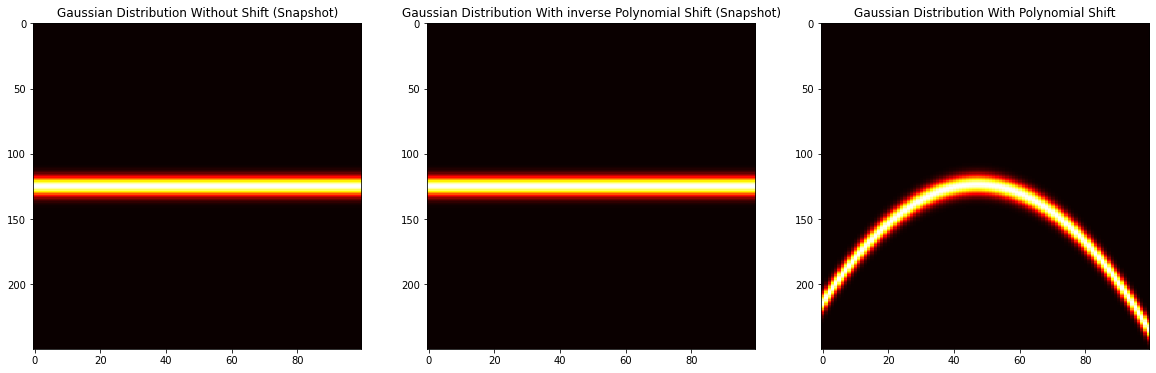

In [10]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Without shift
ax[0].imshow(qs.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Gaussian Distribution Without Shift (Snapshot)')

# With shift
ax[1].imshow(q_reverse_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Gaussian Distribution With inverse Polynomial Shift (Snapshot)')

ax[2].imshow(qs_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[2].set_title('Gaussian Distribution With Polynomial Shift')

In [11]:
#from torch.autograd import gradcheck

#spline_interpolator = SplineInterpolation(params)

#test = gradcheck(spline_interpolator.backward, (qs.double(), cs.double()), eps=1e-5)
#print("Gradient check passed:", test)


## Train a model for polynomial function

In [15]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, p_init_coeffs, q_init_coeffs=[1], type_NN="polynomial"):
        super(ShiftPredictionModel, self).__init__()
        self.p_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in p_init_coeffs[::-1]]
        )
        self.q_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in q_init_coeffs[::-1]]
        )
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.p_coefficients)])
    
    def forward_rat(self,t):
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.q_coefficients)]) + 1e-6 #avoid dividing by zero
        return self.forward_pol(t)/shift2

    def forward_activ(self, t):
        return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(t)
        return output

In [16]:
def total_variation(shift):
    return torch.sum(torch.abs(shift[..., 1:] - shift[..., :-1]))

In [17]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=True)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag_embed((s > 0).to(dtype))[:s.size(0), :s.size(0)]
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output

In [18]:
#condition_number_qs = torch.linalg.cond(qs)
#condition_number_qs.item()

In [19]:
#regularization_term = 0.01 * torch.eye(qs.size(0), qs.size(1))
#qs_tikhonov_regularized = qs + regularization_term
#qs_shifted_tikhonov_regularized = qs_shifted + regularization_term
#condition_number_tikhonov =  torch.linalg.cond(qs_tikhonov_regularized)
#condition_number_tikhonov.item()

In [20]:
#input_matrix = torch.tensor(Q_orig, dtype=torch.double, requires_grad=True) #torch.randn(5, 5, dtype=torch.double, requires_grad=True)
#qs_tikhonov_regularized.requires_grad_(True)

#gradcheck_success = gradcheck(NuclearNormAutograd.apply, qs_tikhonov_regularized.double(), eps=1e-05, atol=1e-4)
#print("Gradient check passed:", gradcheck_success)

In [21]:
p_coefficients_init = [-2,-2,1]
t_values_tensor = torch.linspace(-10, 10, cols,dtype=torch.float64)

In [22]:
def frobenius_norm_squared_loss(y_pred, y):
    difference = y_pred - y
    return torch.norm(difference, 'fro')**2

In [23]:
model = ShiftPredictionModel(p_init_coeffs=p_coefficients_init,type_NN="polynomial")
model.to(torch.float64)

optimizer = optim.Adagrad(model.parameters(), lr=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.LBFGS(model.parameters(), lr=0.01)

#scheduler= optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

#criterion = nn.L1Loss()

# Training the model
epochs = 500
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred_pol = model(t_values_tensor)
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients])
    TQ = spline_interpolator.forward(qs_shifted.double(), y_pred_pol.double())
    #loss = NuclearNormAutograd.apply(TQ)
    loss = frobenius_norm_squared_loss(TQ,qs)
    tv_loss=total_variation(y_pred_pol)
    #loss += 0.1 * tv_loss**2
    
    loss.backward(retain_graph=True)

    optimizer.step()
    
    scheduler.step()
            
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f},Coefficients:{[-coefficients1[::-1][i] for i in range(len(coefficients1))]}{p_coefficients}')

print(f"Model training complete.")

Epoch [0/500], Loss: 1261.1510,Coefficients:[1, -1, -1]tensor([ 1., -2., -2.])
Epoch [100/500], Loss: 370.1480,Coefficients:[1, -1, -1]tensor([ 1.6381, -1.8745, -1.0708])
Epoch [200/500], Loss: 369.9906,Coefficients:[1, -1, -1]tensor([ 1.6381, -1.8742, -1.0707])
Epoch [300/500], Loss: 369.9905,Coefficients:[1, -1, -1]tensor([ 1.6381, -1.8742, -1.0707])
Epoch [400/500], Loss: 369.9905,Coefficients:[1, -1, -1]tensor([ 1.6381, -1.8742, -1.0707])
Model training complete.


Text(0.5, 1.0, 'Snapshot with initial shift')

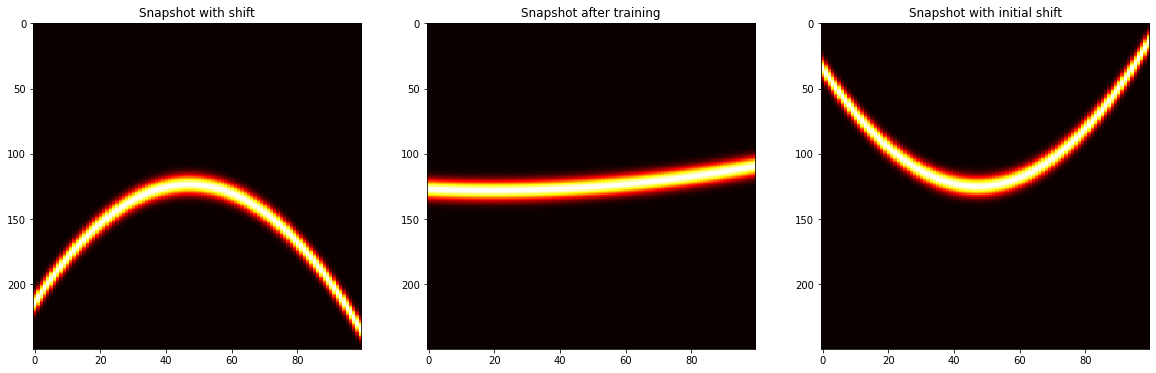

In [25]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Without shift
ax[0].imshow(qs_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Snapshot with shift')

# With shift
ax[1].imshow(TQ.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Snapshot after training')

# With initial shift
initial_cs = torch.tensor(np.polyval(p_coefficients_init,t_values), requires_grad=True)
qs_initial_shift = spline_interpolator.forward(qs_shifted.double(), initial_cs.double())
ax[2].imshow(qs_initial_shift.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[2].set_title('Snapshot with initial shift')

In [26]:
NuclearNormAutograd.apply(qs)

tensor(29.7696, dtype=torch.float64)

## Rational polynomial

In [27]:
p_coefficients_init = [-2,-2,1]
q_coefficients_init = [2,-1,1]

In [28]:
cs_rational_initial = torch.tensor(np.polyval(coefficients1,t_values)/np.polyval(coefficients2,t_values), requires_grad=True) 
qs_shifted_rational = spline_interpolator.forward(qs.double(), cs_rational_initial.double())

In [29]:
model = ShiftPredictionModel(p_init_coeffs=p_coefficients_init,q_init_coeffs=q_coefficients_init,type_NN="rational") # nn.Linear(40,1)
model.to(torch.float64)

optimizer = optim.Adagrad(model.parameters(), lr=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.LBFGS(model.parameters(), lr=0.01)

#scheduler= optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
epochs = 500
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred_pol = model(t_values_tensor)
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients])
    q_coefficients = torch.tensor([p.item() for p in model.q_coefficients])
    TQ = spline_interpolator.forward(qs_shifted_rational.double(), y_pred_pol.double())
    loss = NuclearNormAutograd.apply(TQ)
    tv_loss=total_variation(y_pred_pol)
    #loss += 0.1 * tv_loss**2
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    scheduler.step()
            
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Coefficients:{[-coefficients1[::-1][i] for i in range(len(coefficients1))]}{[coefficients2[::-1][i] for i in range(len(coefficients2))]}{p_coefficients}{q_coefficients}')

print(f"Model training complete.")

Epoch [0/500], Loss: 30.8293, Coefficients:[1, -1, -1][1, -1, 2]tensor([ 1., -2., -2.])tensor([ 1., -1.,  2.])
Epoch [100/500], Loss: 30.5318, Coefficients:[1, -1, -1][1, -1, 2]tensor([ 0.9205, -1.9001, -1.9047])tensor([ 1.0942, -0.9044,  2.0953])



KeyboardInterrupt



Text(0.5, 1.0, 'Snapshot with initial shift')

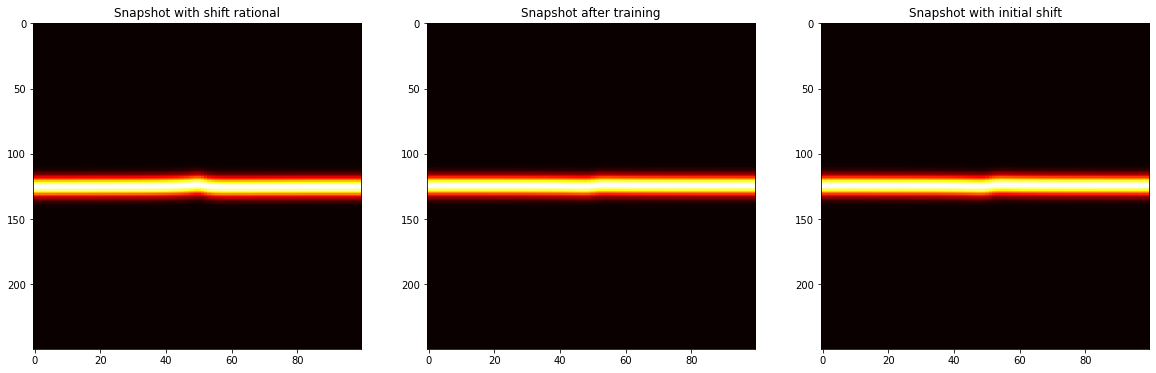

In [249]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Without shift
ax[0].imshow(qs_shifted_rational.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Snapshot with shift rational')

# With shift
ax[1].imshow(TQ.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Snapshot after training')

# With initial shift
initial_cs_rational = torch.tensor(np.polyval(p_coefficients_init,t_values)/np.polyval(q_coefficients_init,t_values), requires_grad=True)
qs_initial_shift_rational = spline_interpolator.forward(qs_shifted_rational.double(), initial_cs_rational.double())
ax[2].imshow(qs_initial_shift_rational.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[2].set_title('Snapshot with initial shift')

## Combine with adm algorithm

In [102]:
import sys
sys.path.append('../lib/')

from sPOD_tools_v2 import shifted_POD_ADM
from transforms import transforms


In [196]:
def generate_data(Nx, Nt):
    L = Nx  # total domain size
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10, 10, cols)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    Q = np.zeros_like(X, dtype=np.float64)
    coefficients = [1, -1, -1]
    t_values = np.linspace(-10, 10, Nt)
    shift1 = np.polyval(coefficients, t_values)
    shift_list = [shift1]
    nmodes = [5]
    for col in range(Nt):
        for row in range(Nx):
            Q[row, col] = gaussian(row, Nx / 2 - shift1[col], sigma)
    Q /= np.max(Q)
    
    return Q, shift_list, nmodes, L, dx

In [200]:
data_shape = [rows,1,1,cols]
fields, _, nmodes, L, dx = generate_data(rows, cols)
coefficients_init = [1,-2,-2]
shift_init = np.polyval(coefficients_init,t_values)
shift_list = [shift_init]
trafos = [
    transforms(data_shape, [L], shifts=shift_list[0], dx=[dx], interp_order=5),
]

Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)


In [201]:
qmat = np.reshape(fields, [rows, cols])
mu = rows * cols / (4 * np.sum(np.abs(qmat))) * 0.01
lambd0 = 1 / np.sqrt(np.maximum(rows, cols)) * 1
ret = shifted_POD_ADM(
    qmat,
    trafos,
    nmodes_max=np.max(nmodes) + 10,
    eps=1e-16,
    Niter=10,
    use_rSVD=True,
    lambd=lambd0,
    mu=mu,
)
sPOD_frames, qtilde, rel_err = ret.frames, ret.data_approx, ret.rel_err_hist
qf = [
    np.squeeze(np.reshape(frame.build_field(), data_shape))
    for trafo, frame in zip(trafos, ret.frames)
]

it=1 rel_err= 9.0e-01 norm(dres) = 4.5e-02 tcpu = 0.01, ranks_frame =  1
it=2 rel_err= 3.3e-01 norm(dres) = 2.9e-02 tcpu = 0.01, ranks_frame =  2
it=3 rel_err= 1.9e-01 norm(dres) = 6.8e-03 tcpu = 0.01, ranks_frame =  3
it=4 rel_err= 1.2e-01 norm(dres) = 3.7e-03 tcpu = 0.01, ranks_frame =  3
it=5 rel_err= 1.2e-01 norm(dres) = 1.8e-12 tcpu = 0.01, ranks_frame =  3
it=6 rel_err= 1.2e-01 norm(dres) = 1.1e-12 tcpu = 0.01, ranks_frame =  3
it=7 rel_err= 4.6e-02 norm(dres) = 3.5e-03 tcpu = 0.01, ranks_frame =  4
it=8 rel_err= 4.1e-02 norm(dres) = 2.5e-04 tcpu = 0.00, ranks_frame =  4
it=9 rel_err= 4.1e-02 norm(dres) = 3.4e-12 tcpu = 0.00, ranks_frame =  4
it=10 rel_err= 4.1e-02 norm(dres) = 2.7e-12 tcpu = 0.00, ranks_frame =  4
CPU time avarege per iteration:  0.005949950218200684


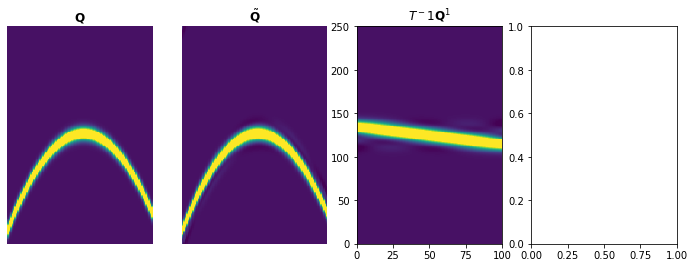

In [211]:
gridspec = {"width_ratios": [1, 1, 1, 1]}
fig, ax = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw=gridspec, num=101)
mycmap = "viridis"
vmin = np.min(qtilde) * 0.6
vmax = np.max(qtilde) * 0.6

ax[0].pcolormesh(qmat, vmin=vmin, vmax=vmax, cmap=mycmap)
ax[0].set_title(r"$\mathbf{Q}$")
# ax[0].axis("image")
ax[0].axis("off")

ax[1].pcolormesh(qtilde, vmin=vmin, vmax=vmax, cmap=mycmap)
ax[1].set_title(r"$\tilde{\mathbf{Q}}$")
# ax[0].axis("image")
ax[1].axis("off")
# the result is a list of the decomposed field.
# each element of the list contains a frame of the decomposition.
# If you want to plot the k-th frame use:
# 1. frame
plot_shifted = True
k_frame = 0
if plot_shifted:
    ax[2].pcolormesh(qf[k_frame], vmin=vmin, vmax=vmax, cmap=mycmap)
    ax[2].set_title(r"$T^" + str(-1) + "\mathbf{Q}^" + str(k_frame + 1) + "$")

In [213]:
model = ShiftPredictionModel(p_init_coeffs=coefficients_init[::-1],type_NN="polynomial")
model.to(torch.float64)
qs_shifted_adm = torch.tensor(sPOD_frames[0].build_field())

optimizer = optim.Adagrad(model.parameters(), lr=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.LBFGS(model.parameters(), lr=0.01)

#scheduler= optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
epochs = 500
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred_pol = model(t_values_tensor)
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients])
    TQ = spline_interpolator.forward(qs_shifted_adm.double(), y_pred_pol.double())
    loss = NuclearNormAutograd.apply(TQ)
    tv_loss=total_variation(y_pred_pol)
    #loss += 0.1 * tv_loss**2
    
    loss.backward(retain_graph=True)

    optimizer.step()
    
    scheduler.step()
            
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f},Coefficients:{[-coefficients1[::-1][i] for i in range(len(coefficients1))]}{p_coefficients}')

print(f"Model training complete.")

Epoch [0/500], Loss: 143.1374,Coefficients:[1, -1, -1]tensor([ 1., -2., -2.])
Epoch [100/500], Loss: 101.8204,Coefficients:[1, -1, -1]tensor([ 0.9793, -1.1016, -0.8892])
Epoch [200/500], Loss: 101.8095,Coefficients:[1, -1, -1]tensor([ 0.9791, -1.1013, -0.8890])
Epoch [300/500], Loss: 101.8095,Coefficients:[1, -1, -1]tensor([ 0.9791, -1.1013, -0.8890])
Epoch [400/500], Loss: 101.8095,Coefficients:[1, -1, -1]tensor([ 0.9791, -1.1013, -0.8890])
Model training complete.


Text(0.5, 1.0, 'Snapshot after training')

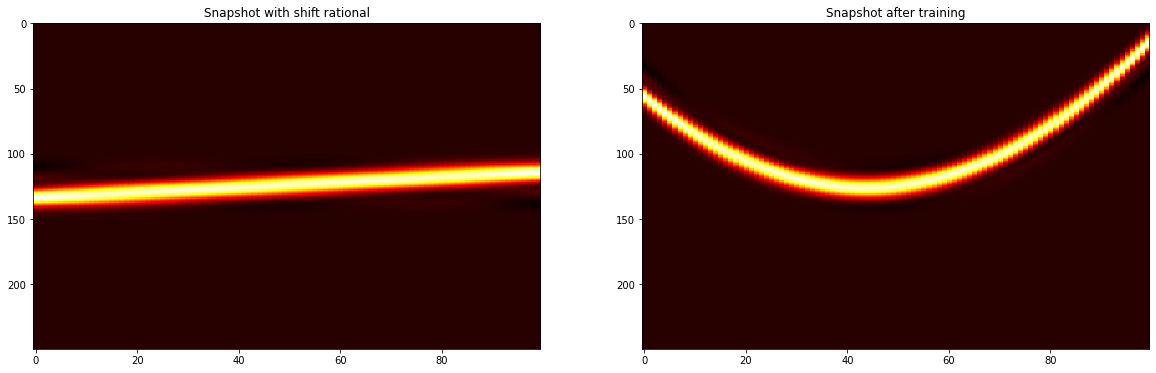

In [214]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Without shift
ax[0].imshow(qs_shifted_adm.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Snapshot with shift rational')

# With shift
ax[1].imshow(TQ.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Snapshot after training')